## Import the libraries

In [1]:
import os
import pandas as pd
import yfinance as yf
from newsapi import NewsApiClient
from datetime import datetime, timedelta
from dotenv import load_dotenv
load_dotenv()

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Fetch the stock OHLC

In [2]:
stock_data= yf.download(tickers= 'MSFT', period= '5y')
stock_data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,222.529999,223.000000,214.809998,217.690002,217.690002,37130100
2021-01-05,217.259995,218.520004,215.699997,217.899994,217.899994,23823000
2021-01-06,212.169998,216.490005,211.940002,212.250000,212.250000,35930700
2021-01-07,214.039993,219.339996,213.710007,218.289993,218.289993,27694500
2021-01-08,218.679993,220.580002,217.029999,219.619995,219.619995,22949400


In [3]:
# Get only the closing price and round to 1 decimal
stock_close= round (stock_data['Close'], 1)
stock_close.tail()

Date
2021-01-04    217.7
2021-01-05    217.9
2021-01-06    212.2
2021-01-07    218.3
2021-01-08    219.6
Name: Close, dtype: float64

In [4]:
# Calculate the daily returns
returns= stock_close.pct_change().dropna()
returns.tail()

Date
2021-01-04   -0.021133
2021-01-05    0.000919
2021-01-06   -0.026159
2021-01-07    0.028746
2021-01-08    0.005955
Name: Close, dtype: float64

In [5]:
returns_df= pd.DataFrame(returns)
returns_df.sort_index(ascending= False, inplace= True)
returns_df.head()

,Close
Date,
2021-01-08,0.005955
2021-01-07,0.028746
2021-01-06,-0.026159
2021-01-05,0.000919
2021-01-04,-0.021133


### Download the VADER Lexicon

In [6]:
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer= SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sathe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
# Reading the News API key enviroment variable
api_key= os.getenv("NEWS_API_KEY2")

# Create a newsapi client
newsapi= NewsApiClient(api_key= api_key)
type (api_key)

str

### Fetch the news

In [35]:
# Fetch the most recent new about ---- stock
stock_news = newsapi.get_everything(q="microsoft AND stock AND price", 
                                    language="en",
                                    sort_by= 'publishedAt'
                                   )

# Print total articles
print(f"Total articles about --- stock: {stock_news['totalResults']}")

# Show sample article
len (stock_news['articles'])

In [36]:
# stock_news['articles'][0]

### Create the sentiment scores DF

In [10]:
stock_sentiment= []

for article in stock_news['articles']:
    try:
        text= article['content']
        date= article['publishedAt'][:10]
        
        # Calculate the polarity score
        sentiment= analyzer.polarity_scores(text)
        compound= sentiment['compound']
        positive= sentiment['pos']
        negative= sentiment['neg']
        neutral= sentiment['neu']
        
        stock_sentiment.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": positive,
            "negative": negative,
            "neutral": neutral
        })
        
    except AttributeError:
        pass
    
# Create dataframe
stock_sentiment_df= pd.DataFrame(stock_sentiment)

In [11]:
# Reorder DataFrame columns
cols = ["date", "text"] #"compound", "positive", "negative", "neutral"]
stock_sentiment_df= stock_sentiment_df[cols]
stock_sentiment_df.head()

,date,text,compound,positive,negative,neutral
0,2021-01-09,getty\r\nLets look at how we closed-end fund (...,0.4019,0.072,0.000,0.928
1,2021-01-08,Jerry Bergquist / Shutterstock.com\r\nOn Tuesd...,0.2732,0.062,0.000,0.938
2,2021-01-08,Bill Gates has thrown his weight behind a £3.2...,-0.6705,0.000,0.147,0.853
3,2021-01-08,Nothing like a 700 percent increase over the p...,0.7343,0.209,0.048,0.743
4,2021-01-08,Hoping to buy a new Xbox Series X? Get in line...,0.0516,0.112,0.081,0.807


In [12]:
stock_sentiment_df.set_index('date', inplace= True)
stock_sentiment_df.tail()

,text,compound,positive,negative,neutral
date,,,,,
2021-01-08,The Dow Jones Industrial Average rallied nearl...,-0.1027,0.066,0.105,0.829
2021-01-08,"The flagship Andurand Commodities Fund,…\r\nEv...",0.1027,0.046,0.000,0.954
2021-01-08,"On January 7, Elon Musk's electric automobile ...",0.3400,0.074,0.000,0.926
2021-01-08,Electric vehicle maker Tesla surpassed Faceboo...,0.0000,0.000,0.000,1.000
2021-01-08,SAN DIEGO--(BUSINESS WIRE)--Robbins Geller Rud...,-0.2263,0.000,0.060,0.940


In [13]:
# Descriptive statistics
stock_sentiment_df.describe()

,compound,positive,negative,neutral
count,20.000000,20.00000,20.000000,20.000000
mean,0.168785,0.07315,0.031750,0.895100
std,0.422731,0.06777,0.048269,0.072287
min,-0.670500,0.00000,0.000000,0.743000
25%,-0.025675,0.00000,0.000000,0.847000
50%,0.187950,0.06150,0.000000,0.906500
75%,0.457650,0.11750,0.065250,0.940000
max,0.734300,0.20900,0.147000,1.000000


In [14]:
# Set current date and the date from one month ago using the ISO format
current_date = pd.Timestamp("2021-01-09", tz="America/New_York").isoformat()
past_date = pd.Timestamp("2020-12-09", tz="America/New_York").isoformat()

## Define a function to fetch the news articles in the last 1 month

In [15]:
# Use newsapi client to get most relevant 20 headlines per day in the past month
def get_headlines(keyword):
    all_headlines = []
    all_dates = []    
    
    date = datetime.strptime(current_date[:10], "%Y-%m-%d")
    end_date = datetime.strptime(past_date[:10], "%Y-%m-%d")
    print(f"Fetching news about '{keyword}'")
    print("*" * 30)
    
    while date > end_date:
        print(f"retrieving news from: {date}")
        articles = newsapi.get_everything(
            q=keyword,
            from_param=str(date),
            to=str(date),
            language="en",
            sort_by="relevancy",
            page=1,
        )
        headlines = []
        
        for i in range(0, len(articles["articles"])):
            headlines.append(articles["articles"][i]["title"])
        
        all_headlines.append(headlines)
        all_dates.append(date)
        date = date - timedelta(days=1)
    
    return all_headlines, all_dates

In [16]:
msft_headlines, dates= get_headlines("microsoft stock price")

Fetching news about 'microsoft stock price'
******************************
retrieving news from: 2021-01-09 00:00:00
retrieving news from: 2021-01-08 00:00:00
retrieving news from: 2021-01-07 00:00:00
retrieving news from: 2021-01-06 00:00:00
retrieving news from: 2021-01-05 00:00:00
retrieving news from: 2021-01-04 00:00:00
retrieving news from: 2021-01-03 00:00:00
retrieving news from: 2021-01-02 00:00:00
retrieving news from: 2021-01-01 00:00:00
retrieving news from: 2020-12-31 00:00:00
retrieving news from: 2020-12-30 00:00:00
retrieving news from: 2020-12-29 00:00:00
retrieving news from: 2020-12-28 00:00:00
retrieving news from: 2020-12-27 00:00:00
retrieving news from: 2020-12-26 00:00:00
retrieving news from: 2020-12-25 00:00:00
retrieving news from: 2020-12-24 00:00:00
retrieving news from: 2020-12-23 00:00:00
retrieving news from: 2020-12-22 00:00:00
retrieving news from: 2020-12-21 00:00:00
retrieving news from: 2020-12-20 00:00:00
retrieving news from: 2020-12-19 00:00:00
r

In [19]:
msft_headlines[:5]

[['The Retirement-Ready 6.4% Dividend Your Friends Have No Clue About'],
 ['Is Microsoft Stock a Buy?',
  'Dump Twilio, Buy This Explosive Growth Stock Instead',
  'Micron Is Still Rallying After its Strong Earnings. Wall Street Is More Bullish.',
  'Bitcoin Tests $40K, May Hit "$50K to $100K": ETFs to Play',
  'Deals for 2021',
  'Primecap Curbs Holdings of Cree, BioMarin Pharmaceutical',
  "Elon Musk overtakes Jeff Bezos as world's richest person",
  'The Zacks Analyst Blog Highlights: ArcelorMittal, Ubiquiti, Rio Tinto, General Motors and Liberty Broadband',
  'Elon Musk Is Now The World’s Richest Person',
  'Dow Jones Rallies As Economy Loses Jobs; Nio Hits New Buy Point, While Tesla Surges On New Model Y',
  'Notice of Lead Plaintiff Deadline for Shareholders in the SolarWinds Corporation Class Action Lawsuit',
  'Deadline Reminder: Law Offices of Howard G. Smith Reminds Investors of Looming Deadline in the Class Action Lawsuit Against SolarWinds Corporation (SWI)',
  'Tesla Power

### Calculate the avg compound sentiment score

In [39]:
# Create function that computes average compound sentiment of headlines for each day
def headline_sentiment_summarizer_avg(headlines):
    sentiment = []
    for day in headlines:
        day_score = []
        for article in day:
            if article == None:
                continue
            else:
                day_score.append(analyzer.polarity_scores(article)["compound"])
        sentiment.append(sum(day_score) / len(day_score))
    return sentiment

In [40]:
# Get averages of each topics sentiment
msft_avg = headline_sentiment_summarizer_avg(msft_headlines)

In [41]:
# Combine Sentiment Averages into DataFrame
topic_sentiments = pd.DataFrame(
    {
        "msft_avg": msft_avg
    }
)

topic_sentiments.head()

,msft_avg
0,0.226300
1,0.204130
2,0.231485
3,0.130970
4,0.208435


In [32]:
# Set the index value of the sentiment averages DataFrame to be the series of dates.
topic_sentiments.index = pd.to_datetime(dates)

topic_sentiments.head()

,msft_avg
2021-01-09,0.226300
2021-01-08,0.204130
2021-01-07,0.231485
2021-01-06,0.130970
2021-01-05,0.208435


### Merge the close prices and sentiment score

In [34]:
# Merge with MSFT returns
topic_sentiments_merged = returns_df.join(topic_sentiments).dropna(how="any")
topic_sentiments_merged.tail()

,Close,msft_avg
Date,,
2020-12-16,0.024288,0.077715
2020-12-15,-0.000467,0.128620
2020-12-14,0.004219,0.109720
2020-12-11,0.013302,0.124305
2020-12-10,-0.006138,0.102175


## Tokenization, Lemmatization

In [42]:
# Importing the Libraries and Functions
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [43]:
# Instantiate the lemmatizer
lemmatizer= WordNetLemmatizer()

In [44]:
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the stop words
    stop_words= set (stopwords.words('english'))
   
    # Remove the punctuation and substitute
    non_alpha= re.compile('[^a-zA-Z ]')
    re_clean= non_alpha.sub('', str (text))
    
    # Tokenize the words
    words= word_tokenize(re_clean)
    
    # Lemmatize Article words into root words
    root_words= []
    for values in words:
        root_words.append(lemmatizer.lemmatize(values))
        
    # Remove stop words and Convert the words to lowercase
    tokens= []
    for all_words in root_words:
        if all_words.lower() not in stop_words:
            tokens.append(all_words.lower())
    
    return tokens

In [45]:
# Apply the tokenizer function to the news text column
stock_sentiment_df['tokenized']= stock_sentiment_df['text'].apply(tokenizer)
stock_sentiment_df.head()

,text,compound,positive,negative,neutral,tokenized
date,,,,,,
2021-01-09,getty\r\nLets look at how we closed-end fund (...,0.4019,0.072,0.000,0.928,"[gettylets, look, closedend, fund, cef, invest..."
2021-01-08,Jerry Bergquist / Shutterstock.com\r\nOn Tuesd...,0.2732,0.062,0.000,0.938,"[jerry, bergquist, shutterstockcomon, tuesday,..."
2021-01-08,Bill Gates has thrown his weight behind a £3.2...,-0.6705,0.000,0.147,0.853,"[bill, gates, ha, thrown, weight, behind, bill..."
2021-01-08,Nothing like a 700 percent increase over the p...,0.7343,0.209,0.048,0.743,"[nothing, like, percent, increase, past, year,..."
2021-01-08,Hoping to buy a new Xbox Series X? Get in line...,0.0516,0.112,0.081,0.807,"[hoping, buy, new, xbox, series, x, get, line,..."


## N-grams, WordCloud

In [46]:
# Import the libraries and functions
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10.0, 10.0]


Bad key "text.kerning_factor" on line 4 in
C:\Satheesh\Anaconda\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


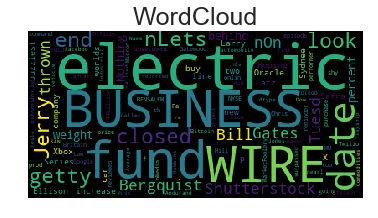

In [47]:
# Generate the word cloud
returns_big_text= ''.join (str (stock_sentiment_df["text"]))

returns_wc= WordCloud().generate(returns_big_text)

plt.imshow(returns_wc)
plt.axis("off")
plt.title('WordCloud', fontsize= 25)
plt.show()